In [1]:
import os
import torch

#%matplotlib inline
#import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
import numpy as np
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_add
from torch_geometric.nn import MetaLayer
import torch.nn as nn
from torch.nn import Sequential, Linear, ReLU, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn import MessagePassing
#from torchvision import transforms
from torch_geometric.loader import DataLoader



In [2]:
import matplotlib.pyplot as plt

In [47]:
#load the loss function 
loss_mass = np.load('mass_loss_best_all.npz')

train_loss = loss_mass['arr_0']
valid_loss = loss_mass['arr_1']

In [49]:
loss_mass_best = np.load('mass_loss_best.npz')

train_loss_best = loss_mass_best['arr_0']
valid_loss_best = loss_mass_best['arr_1']

In [30]:
valid_loss_best

array([0.02008844, 0.02068292, 0.01968241, 0.01905888, 0.01810461,
       0.01324647, 0.0095574 , 0.00944985, 0.00848955, 0.00693352,
       0.00638914, 0.00634194, 0.00784586, 0.00640183, 0.00628499,
       0.00802239, 0.00855598, 0.00636805, 0.00580073, 0.00594729,
       0.00661251, 0.00609655, 0.00723106, 0.00606127, 0.00789624,
       0.00703132, 0.00639519, 0.00615144, 0.0076297 , 0.00657365,
       0.00644638, 0.00649019, 0.00633321, 0.00694992, 0.00680026,
       0.0064389 , 0.00653303, 0.0066942 , 0.00644071, 0.00607615,
       0.00801337, 0.00786922, 0.00594205, 0.00810538, 0.00629069,
       0.0064231 , 0.0067328 , 0.00657675, 0.00592139, 0.00749653,
       0.00620055, 0.00651491, 0.00644452, 0.00692842, 0.00657869,
       0.00662079, 0.00620183, 0.00652068, 0.0067031 , 0.00672661,
       0.00638042, 0.0060053 , 0.00642799, 0.00742891, 0.00653364,
       0.00650747, 0.00748805, 0.00746262, 0.00669167, 0.00679677,
       0.00643382, 0.00660476, 0.00721083, 0.00777237, 0.00663

Text(0.5, 0, 'epochs')

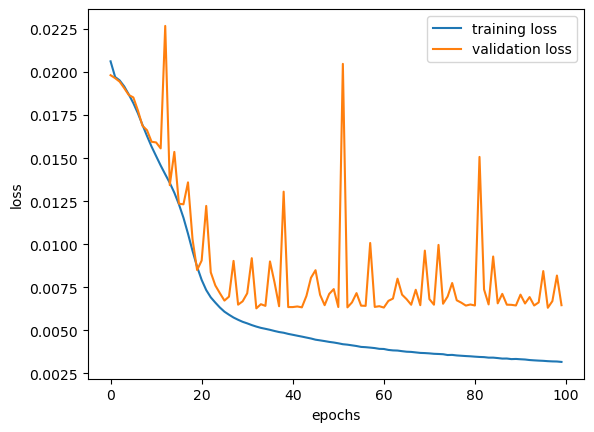

In [52]:
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
#plt.plot(valid_loss_best)
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

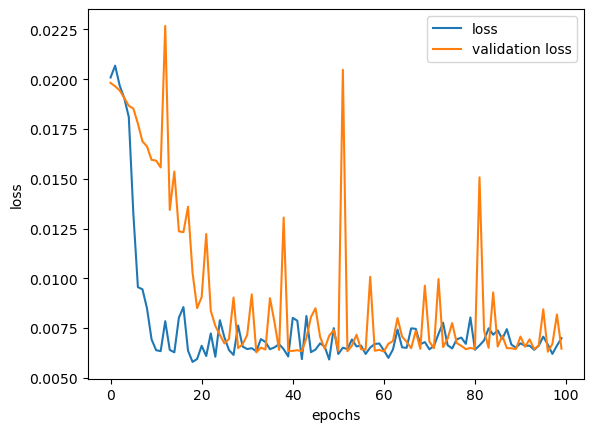

In [57]:
plt.plot(valid_loss_best[:100], label='loss')
plt.plot(valid_loss, label='validation loss')
#plt.plot(valid_loss_best)
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')

In [55]:
min(train_loss)

0.0031695339917606037

In [56]:
min(train_loss_best)

0.0020408233900951964

In [3]:
test_dataset_all = torch.load('masswdm_test_menos10_all.pt')

In [46]:
len(test_dataset_all)

12561

In [5]:
test_dataset_all[0]

Data(x=[6, 12], edge_index=[2, 30], edge_attr=[30, 1], y=0.3556100130081177, u=[1, 6])

In [23]:
train_dataset = torch.load('masswdm_train_menos10_all.pt')

In [45]:
len(train_dataset)

58473

In [4]:
class EdgeModel(nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hidden_dim, global_in):
        super().__init__()

        layers = [Linear(node_in*2 + edge_in, hidden_dim),
                  ReLU(),
                  Linear(hidden_dim, edge_out)]

        self.edge_mlp = Sequential(*layers)


    def forward(self, src, dest, edge_attr, u, batch):
        # src, dest: [E, F_x], where E is the number of edges
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.

        out = torch.cat([src, dest, edge_attr], dim=1)
        #out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        out = self.edge_mlp(out)
        return out

      
 #MPL que acutaliza el valor de los nodos
class NodeModel(nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hidden_dim, global_in):
        super().__init__()

        layers = [Linear(node_in + 3*edge_in + global_in, hidden_dim),
                  ReLU(),
                  Linear(hidden_dim, node_out)]

        self.node_mlp = Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.

        row, col = edge_index
        out = edge_attr

        # Multipooling layer
        out1 = scatter_add(out, col, dim=0, dim_size=x.size(0))
        out2 = scatter_max(out, col, dim=0, dim_size=x.size(0))[0]
        out3 = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out1, out2, out3, u[batch]], dim=1)

        out = self.node_mlp(out)
        return out

class GNN(nn.Module):
    def __init__(self, node_features, n_layers, hidden_dim, dim_out):
        super().__init__()

        self.n_layers = n_layers
        self.dim_out = dim_out
        # Number of input node features = 10
        node_in = node_features
        edge_in = 1
        edge_out = 1
        global_in = 6
        node_out = node_features
        hidden_dim = hidden_dim

        #node_in = node_out
        #edge_in = edge_out

        layers = []
        for i in range(n_layers-1):
            lay = MetaLayer(node_model=NodeModel(node_in, node_out, edge_in, edge_out, hidden_dim, global_in),
                        edge_model=EdgeModel(node_in, node_out, edge_in, edge_out, hidden_dim, global_in))
            layers.append(lay)

        self.layers = ModuleList(layers)

        self.outlayer = Sequential(Linear(3*node_out + global_in, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, self.dim_out))

    def forward(self, data):
        x, edge_index, edge_attr, u = data.x, data.edge_index, data.edge_attr, data.u

        for layer in self.layers:
            #print('hello')
            x, edge_attr, _ = layer(x, edge_index, edge_attr, u, batch=data.batch)

        # Multipooling layer
        addpool = global_add_pool(x, data.batch)
        meanpool = global_mean_pool(x, data.batch)
        maxpool = global_max_pool(x, data.batch)

        out = torch.cat([addpool,meanpool,maxpool, u], dim=1)
        # Final linear layer
        out = self.outlayer(out)

        return out

#model = GNN(node_features = 12, n_layers = 2, hidden_dim = 88, dim_out = 1)
model = GNN(node_features = 12, n_layers = 3, hidden_dim = 119, dim_out = 1)


In [5]:
model.load_state_dict(torch.load('model_mass_best_all.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
#train_loader_all = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader_all = DataLoader(test_dataset_all, batch_size=1, shuffle=False)

In [7]:
def prediction(data_pred):
    model.eval()

    pred_model = model(data_pred)    
    

    y_true = data_pred.y
    y_true_new = y_true.float()

    y_pred = pred_model

    return y_true_new, y_pred


In [27]:
true_list_train = []
pred_list_train = []
for data in train_loader_all:
    true_train, pred_train = prediction(data)
    pred_train = pred_train.detach().numpy()
    true_train = true_train.detach().numpy()
    true_list_train.append(true_train)
    pred_list_train.append(pred_train)
    #print(data.y)
    #print(out)

In [28]:
true_list_train =np.array(true_list_train)
pred_list_train =np.array(pred_list_train)

In [30]:
pred_list_train = pred_list_train.reshape(len(pred_list_train),1)

Text(0.5, 1.0, 'Train set')

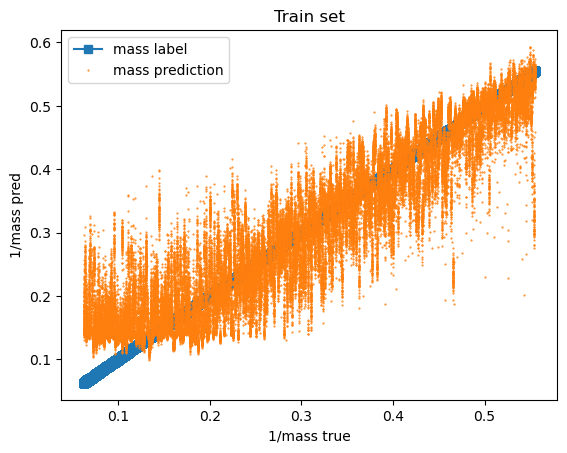

In [31]:
plt.plot(true_list_train, true_list_train, marker='s', label='mass label')
plt.plot(true_list_train, pred_list_train, marker='o', lw=0, ms=0.5,label='mass prediction')
#plt.axvline(x=true_list[1,0])
plt.xlabel('1/mass true')
plt.ylabel('1/mass pred')
plt.legend()
plt.title('Train set')

In [15]:
len(test_dataset)

891

In [8]:
#train
true_list = []
pred_list = []
for data in test_loader_all:
    true, pred = prediction(data)
    pred = pred.detach().numpy()
    true = true.detach().numpy()
    true_list.append(true)
    pred_list.append(pred)
    #print(data.y)
    #print(out)

In [9]:
true_list =np.array(true_list)
pred_list =np.array(pred_list)

In [10]:
len(true_list)

12561

In [35]:
len(test_dataset_all)

12561

In [11]:
pred_list = pred_list.reshape(len(pred_list),1)

Text(0.5, 1.0, 'Test set')

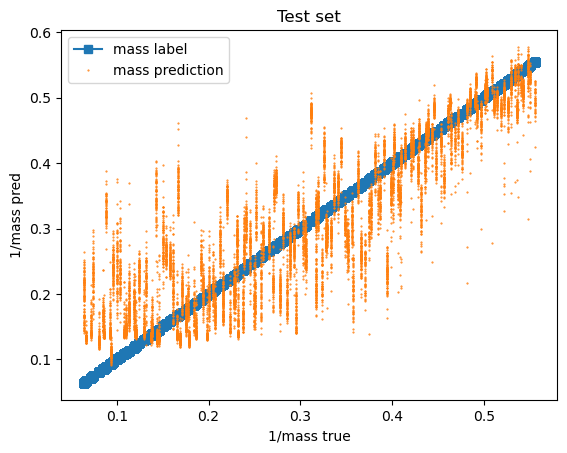

In [12]:
plt.plot(true_list, true_list, marker='s', label='mass label')
plt.plot(true_list, pred_list, marker='o', lw=0, ms=0.5,label='mass prediction')

#plt.axvline(x=true_list[1,0])
plt.xlabel('1/mass true')
plt.ylabel('1/mass pred')
plt.legend()
plt.title('Test set')

In [22]:
1/true_list

array([[2.8120694],
       [2.8120694],
       [2.8120694],
       ...,
       [5.444844 ],
       [5.444844 ],
       [5.444844 ]], dtype=float32)

Text(0.5, 1.0, 'Train set')

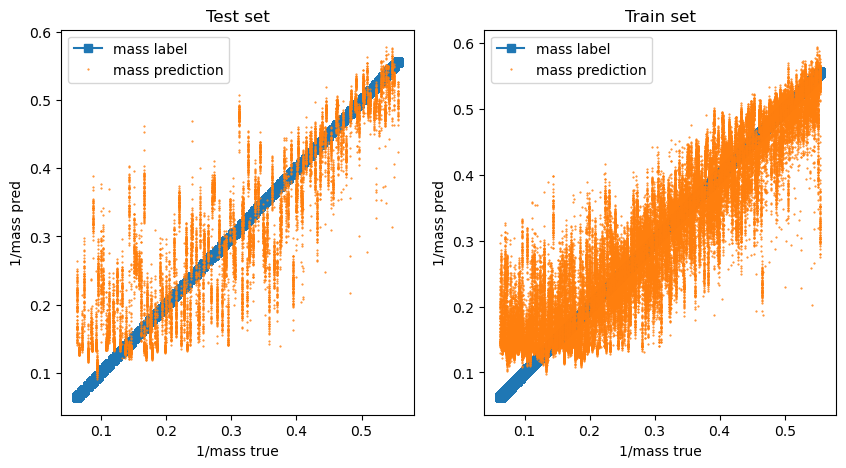

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(true_list, true_list, marker='s', label='mass label')
ax[0].plot(true_list, pred_list, marker='o', lw=0, ms=0.5,label='mass prediction')

#plt.axvline(x=true_list[1,0])
ax[0].set_xlabel('1/mass true')
ax[0].set_ylabel('1/mass pred')
ax[0].legend()
ax[0].set_title('Test set')

ax[1].plot(true_list_train, true_list_train, marker='s', label='mass label')
ax[1].plot(true_list_train, pred_list_train, marker='o', lw=0, ms=0.5,label='mass prediction')

#plt.axvline(x=true_list[1,0])
ax[1].set_xlabel('1/mass true')
ax[1].set_ylabel('1/mass pred')
ax[1].legend()
ax[1].set_title('Train set')

In [33]:
#train
true_list = []
pred_list = []
for data in train_loader:
    true, pred = prediction(data)
    pred = pred.detach().numpy()
    true = true.detach().numpy()
    true_list.append(true)
    pred_list.append(pred)
    #print(data.y)
    #print(out)

In [34]:
true_list =np.array(true_list)
pred_list =np.array(pred_list)

In [35]:
pred_list = pred_list.reshape(len(pred_list),1)

Text(0.5, 1.0, 'Train set')

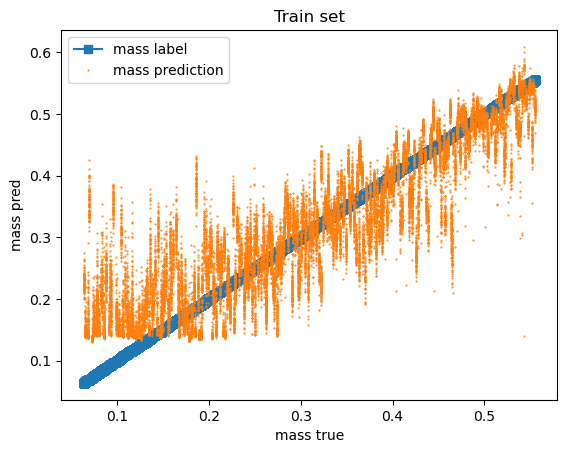

In [38]:
plt.plot(true_list, true_list, marker='s', label='mass label')
plt.plot(true_list, pred_list, marker='o', lw=0, ms=0.5,label='mass prediction')
#plt.axvline(x=true_list[1,0])
plt.xlabel('mass true')
plt.ylabel('mass pred')
plt.legend()
plt.title('Train set')